In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import get_folds
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v1"

In [3]:
INPUT_PATH = Path("../input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False)
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv")

folds_df = get_folds()
train_metadata = train_metadata.merge(folds_df, on=["isic_id", "patient_id"], how="inner")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

Train data size: (401059, 57)
Test data size: (3, 44)


In [4]:
def stat_features(df, group_cols, value_col, stats):
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    df[f"{value_col}_mean_diff"] = df[value_col] - df[f"{value_col}_mean"]
    return df


def feature_engineering(df):
    # v1 features
    df["lesion_size_ratio"]              = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["hue_contrast"]                   = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["normalized_lesion_size"]         = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["overall_color_difference"]       = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    patient_num_images = df.groupby("patient_id", as_index=False)["isic_id"].count().rename(columns={"isic_id": "num_images"})
    df = df.merge(patient_num_images, on="patient_id", how="left")
    
    # v2 features
    df["max_minus_min_lesion_size"] = df["clin_size_long_diam_mm"] - df["tbp_lv_minorAxisMM"]
    
    df["tbp_lv_A_diff"] =  df["tbp_lv_Aext"] - df["tbp_lv_A"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_A_diff", ["mean"])
    
    df["tbp_lv_B_diff"] =  df["tbp_lv_Bext"] - df["tbp_lv_B"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_B_diff", ["mean"])
    
    df["tbp_lv_L_diff"] =  df["tbp_lv_Lext"] - df["tbp_lv_L"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_diff", ["mean"])
    
    df["tbp_lv_L_std_diff"] =  df["tbp_lv_stdLExt"] - df["tbp_lv_stdL"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_std_diff", ["mean"])
    
    return df

train_metadata = feature_engineering(train_metadata.copy())
test_metadata = feature_engineering(test_metadata.copy())

In [5]:
id_column = "isic_id"
target_column = "final_target"
group_column = "patient_id"
ord_categorical_features = [
    "sex", 
    "anatom_site_general", 
    "tbp_tile_type", 
    "tbp_lv_location", "tbp_lv_location_simple",
    "attribution", "copyright_license"
]
ohe_categorical_features = []
numerical_features = [
    "age_approx", 
    "clin_size_long_diam_mm",
    "tbp_lv_A", "tbp_lv_Aext",
    "tbp_lv_B", "tbp_lv_Bext",
    "tbp_lv_C", "tbp_lv_Cext",
    "tbp_lv_H", "tbp_lv_Hext",
    "tbp_lv_L", "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border", "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z",
    "lesion_size_ratio", "hue_contrast", "normalized_lesion_size", "overall_color_difference", "num_images"
]

In [6]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [7]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata["fold"]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 46


In [8]:
def pauc_80(preds, data):
    score_value = compute_pauc(data.get_label(), preds, min_tpr=0.8)   
    return 'pauc_80', score_value, True


params = {
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 63,
    "learning_rate": 0.01,
    "bagging_freq": 5,
    "bagging_fraction": 0.6,
    "bagging_seed": cfg.seed,
    "feature_fraction": 0.3,
    "feature_fraction_seed": cfg.seed,
    "lambda_l1": 0.95,
    "lambda_l2": 0.95,
    "verbosity": -1
}
num_rounds = 2500
es_rounds = 200
log_rounds = 50

In [9]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    lgb_dataset_dev = lgb.Dataset(X_dev, label=y_dev, categorical_feature=categorical_features, free_raw_data=False)
    lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(
        params,
        lgb_dataset_dev,
        num_boost_round=num_rounds,
        valid_sets=[lgb_dataset_val],
        feval=pauc_80,
        callbacks=[early_stopping(stopping_rounds=es_rounds), log_evaluation(log_rounds)],
    )
    
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    val_scores = dict(model.best_score["valid_0"])
    
    val_auc_scores[f"fold_{fold}"] = val_scores["auc"]
    val_pauc_scores[f"fold_{fold}"] = val_scores["pauc_80"]
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_index] = val_preds
    print("\n")

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.931613	valid_0's pauc_80: 0.147766
[100]	valid_0's auc: 0.937806	valid_0's pauc_80: 0.151397
[150]	valid_0's auc: 0.942852	valid_0's pauc_80: 0.155529
[200]	valid_0's auc: 0.943996	valid_0's pauc_80: 0.156272
[250]	valid_0's auc: 0.945987	valid_0's pauc_80: 0.157757
[300]	valid_0's auc: 0.94731	valid_0's pauc_80: 0.159106
[350]	valid_0's auc: 0.948495	valid_0's pauc_80: 0.160156
[400]	valid_0's auc: 0.948868	valid_0's pauc_80: 0.16053
[450]	valid_0's auc: 0.948224	valid_0's pauc_80: 0.159804
[500]	valid_0's auc: 0.949286	valid_0's pauc_80: 0.160935
[550]	valid_0's auc: 0.950253	valid_0's pauc_80: 0.161591
[600]	valid_0's auc: 0.950537	valid_0's pauc_80: 0.161587
[650]	valid_0's auc: 0.950076	valid_0's pauc_80: 0.16107
[700]	valid_0's auc: 0.950629	valid_0's pauc_80: 0.161641
[750]	valid_0's auc: 0.950

<Axes: >

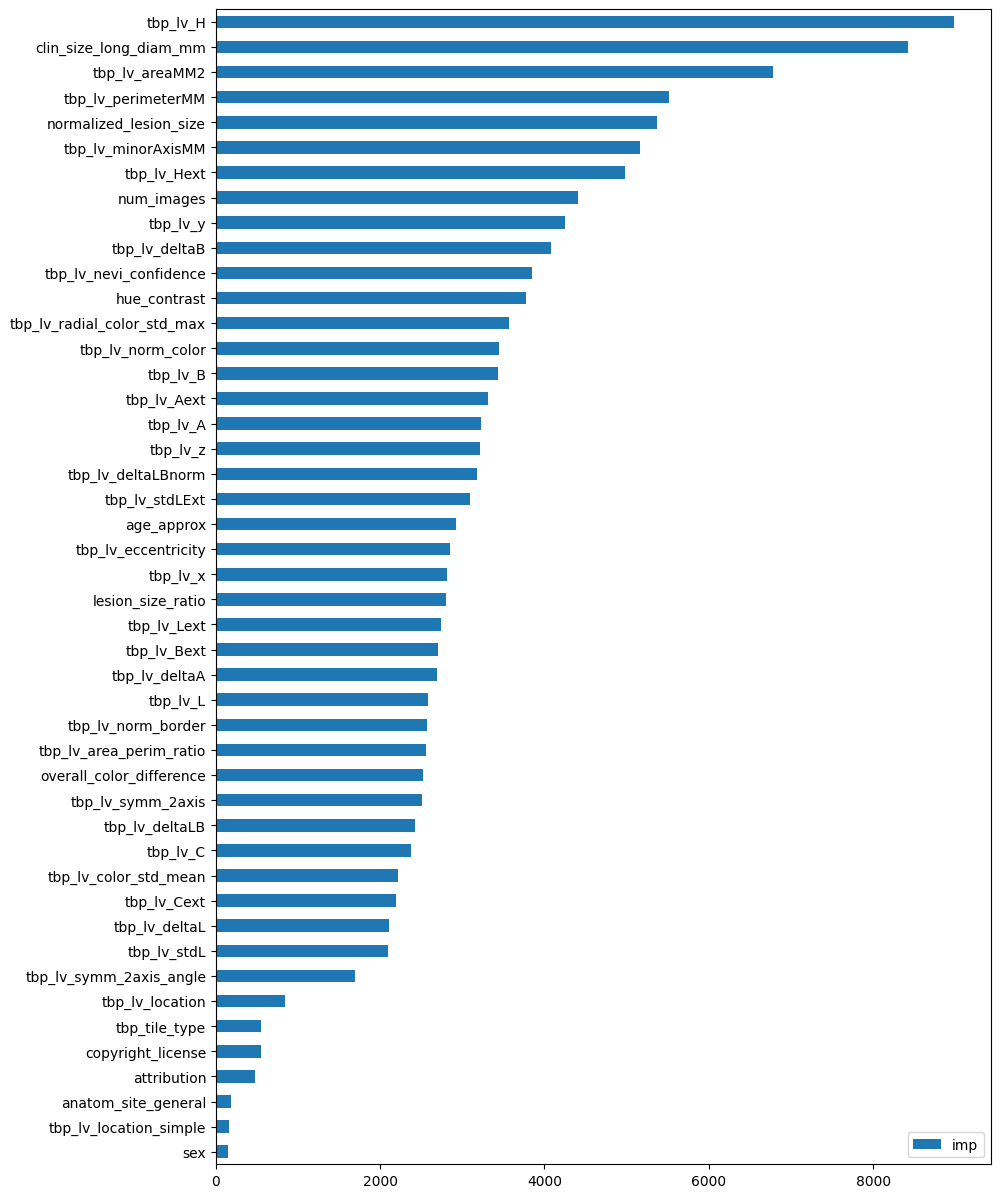

In [10]:
feature_importances = 0
for fold in all_folds:
    model = lgb.Booster(model_file=MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    if fold == 1:
        feature_names = model.feature_name()
    feature_importances += model.feature_importance(importance_type="gain")
feature_importances /= len(all_folds)

imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 15))

In [11]:
metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)